# Expe 1, noise tagging condition, individual analysis of participant A2

In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A2/converted/trialinfo_matrix_A2_cleanedtrials.mat'
data_file = '/data/A2/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_2.fif'

# Posterior electrodes
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz'] 
# Best electrodes in frequency tagging condition
freqtag_electrodes = ['Iz', 'POz', 'PO3', 'P1', 'Pz', 'O2']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from noise_tagging_funs import normalize_per_trial, generate_noise_periods, cross_cor_nois, compute_other_trial_crosscorr

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']

# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif ...


/tmp/ipykernel_85470/448556551.py:22: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
467 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

# Keep only trials without targets
epochs = epochs['target_binary == 0']

# Resample to the projectors sampling rate
epochs.resample(480)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,380
Events,1: 380
Time range,-1.000 – 2.298 s
Baseline,off


In [5]:
epochs_noistag = epochs['tagging_type==1'].copy()
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s


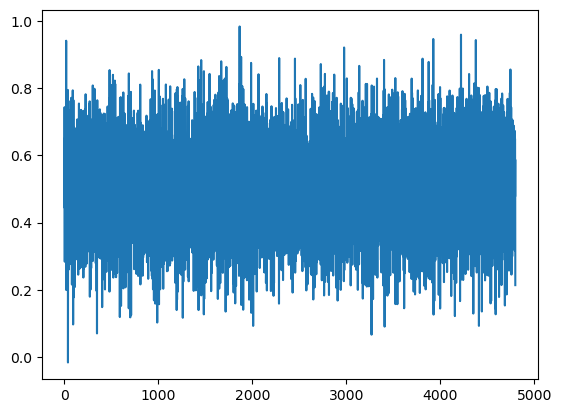

In [6]:
# First noise tag at block 15 trial 32
plt.plot(noise_stims[14,31,0,:].T)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [7]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [8]:
noise_stims_tr.shape

(480, 2, 4800)

## 1. Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

In [9]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1
tmin_display = int(.8*sfreq) #Display from -.2 s

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

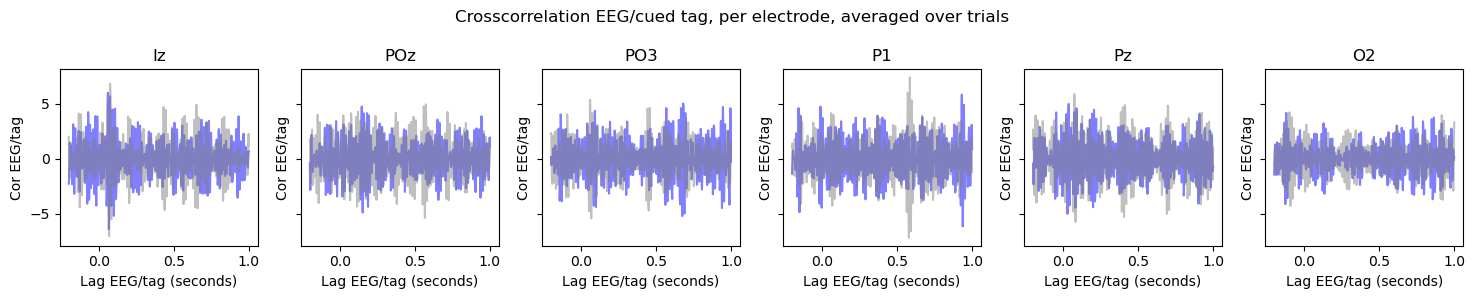

In [10]:
fig, ax = plt.subplots(1,len(freqtag_electrodes), figsize=(15, 3), sharey=True, sharex=True)
for e, elec in enumerate(freqtag_electrodes):
    ax[e].plot(times[tmin_display:], cor_with_cued[:, e, tmin_display:].mean(axis=0).T, color='blue', alpha=0.5)
    ax[e].plot(times[tmin_display:], cor_with_uncued[:, e, tmin_display:].mean(axis=0).T, color='grey', alpha=0.5)

    ax[e].set_title(elec)
    ax[e].set_xlabel('Lag EEG/tag (seconds)')
    ax[e].set_ylabel('Cor EEG/tag')
plt.suptitle('Crosscorrelation EEG/cued tag, per electrode, averaged over trials')
plt.tight_layout()
plt.show()


Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_85470/493135235.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


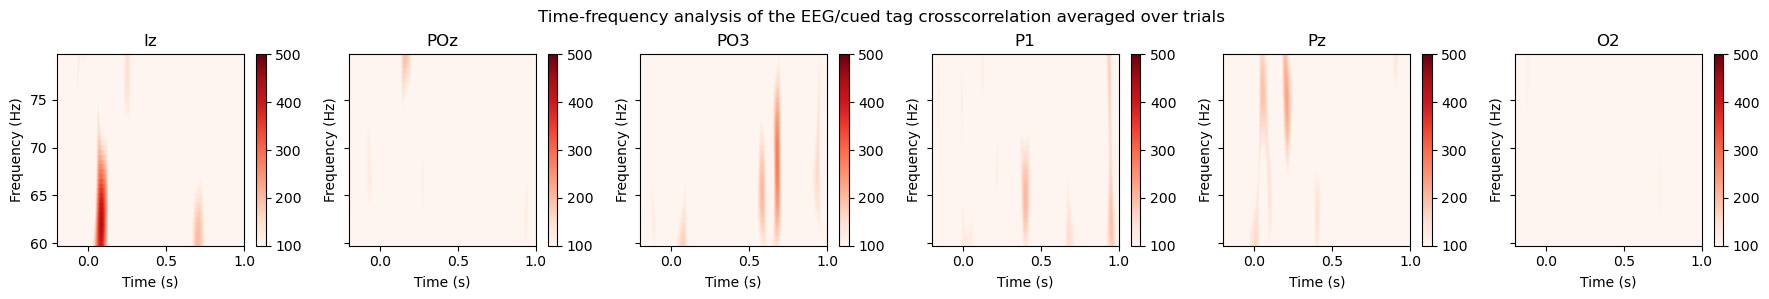

In [11]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().pick(freqtag_electrodes).crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).resample(sfreq)
# Do the time frequency analysis
tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)
# Store in MNE format
tfr = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([tfr[:,:,:,:].mean(axis=0)]), epochs_noistag_cropped.times, freqs)

# Plot
fig, axes = plt.subplots(1, len(freqtag_electrodes), figsize=(18, 3), sharey = True) 
axes = axes.flatten() 
channels = epochs_noistag_cropped.info['ch_names']
for e, (channel, ax) in enumerate(zip(channels, axes)):
    tfr.plot(
        [channel],
        tmin=-.2,
        baseline=(None,0),
        vlim=(100, 500),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
plt.tight_layout()
plt.suptitle('Time-frequency analysis of the EEG/cued tag crosscorrelation averaged over trials')
plt.show()



### 1.1 Comparing max cross-correlation pre vs post display

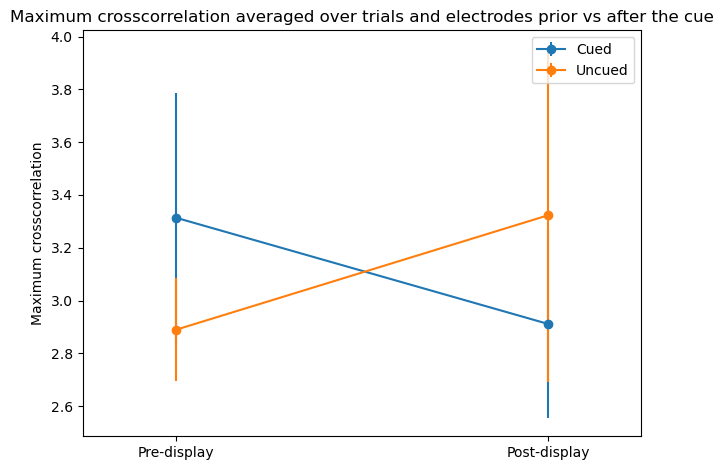

In [12]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = np.abs(normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_cued = np.abs(normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = np.abs(normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_uncued = np.abs(normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-display', 'Post-display'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

In [13]:
# Export for group analysis
crosscor_prepost = {}
crosscor_prepost['cued_pre'] = np.abs(normalize_per_trial(cor_with_cued.mean(axis=0))[:,:cor_with_cued.shape[-1]//2+1]).max(axis=-1)
crosscor_prepost['cued_post'] = np.abs(normalize_per_trial(cor_with_cued.mean(axis=0))[:,cor_with_cued.shape[-1]//2:]).max(axis=-1)
crosscor_prepost['uncued_pre'] = np.abs(normalize_per_trial(cor_with_uncued.mean(axis=0))[:,:cor_with_uncued.shape[-1]//2+1]).max(axis=-1)
crosscor_prepost['uncued_post'] = np.abs(normalize_per_trial(cor_with_uncued.mean(axis=0))[:,cor_with_uncued.shape[-1]//2:]).max(axis=-1)
crosscor_prepost['uncued_post'] 
crosscor_prepost_df = pd.DataFrame(crosscor_prepost)
crosscor_prepost_df = crosscor_prepost_df.melt()
crosscor_prepost_df[['cued', 'prepost']] = crosscor_prepost_df['variable'].str.split('_', expand=True)
crosscor_prepost_df = crosscor_prepost_df.drop('variable', axis=1)
crosscor_prepost_df.to_csv('files/A2_crosscor_prepost.csv',index=False)

### 1.2 Comparing max cross-correlation on displayed trial vs others

In [14]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 1

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

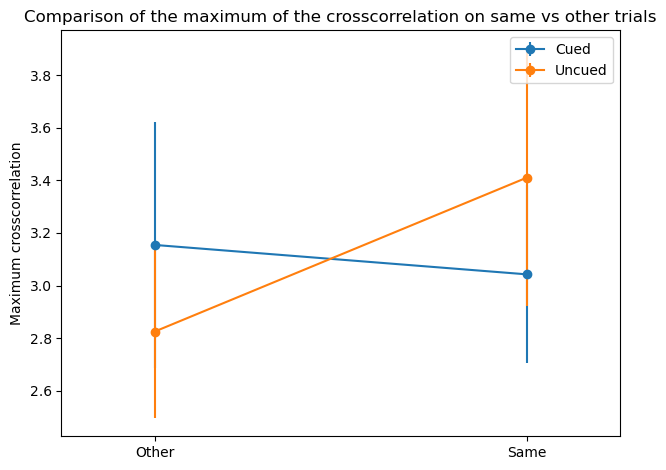

In [15]:
# Set seed for reproducibility of the random choice on other trials
np.random.seed(1)

same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])
other_cued
plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0)))).max(axis=-1).mean(), np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0)))).max(axis=-1).mean()],
                yerr=[np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0)))).max(axis=-1).std(), np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0)))).max(axis=-1).std()], fmt='o-', label='Cued')
plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0)))).max(axis=-1).mean(), np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0)))).max(axis=-1).mean()],
                yerr=[np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0)))).max(axis=-1).std(), np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0)))).max(axis=-1).std()], fmt='o-', label='Uncued')
plt.xticks([0,1],['Other','Same'])
plt.title('Comparison of the maximum of the crosscorrelation on same vs other trials')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

In [16]:
# Export for group analysis
crosscor_sameother = {}
crosscor_sameother['same_cued'] = np.abs(normalize_per_trial(np.array(same_cued).mean(axis=(0)))).max(axis=-1)
crosscor_sameother['same_uncued'] = np.abs(normalize_per_trial(np.array(same_uncued).mean(axis=(0)))).max(axis=-1)
crosscor_sameother['other_cued'] = np.abs(normalize_per_trial(np.array(other_cued).mean(axis=(0)))).max(axis=-1)
crosscor_sameother['other_uncued'] = np.abs(normalize_per_trial(np.array(other_uncued).mean(axis=(0)))).max(axis=-1)
crosscor_sameother_df = pd.DataFrame(crosscor_sameother)
crosscor_sameother_df = crosscor_sameother_df.melt()
crosscor_sameother_df[['trial_type', 'cued']] = crosscor_sameother_df['variable'].str.split('_', expand=True)
crosscor_sameother_df = crosscor_sameother_df.drop('variable', axis=1)
crosscor_sameother_df.to_csv('files/A2_crosscor_sameother_cueduncued.csv',index=False)

## 2. Cross-correlation of the averaged tags (tag duration from 0 to 2s)

The EEG from -1 to 2.3s is correlated with the tags from 0 to 2s (positive time lag up to 300ms). 
All trials, including the 20% where there was a target are included. 
The EEG is correlated with the average of the two displayed tags instead of each tag.
Crosscorrelation is computed for all posterior electrodes then allows to select the best.

In [17]:
tmin_eeg, tmax_eeg = -1, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

cor_with_avg_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = relevant_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = True)

cor_with_avg_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes = relevant_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = True)

cor_with_avg = np.concatenate([cor_with_avg_for_cuedR,cor_with_avg_for_cuedL])

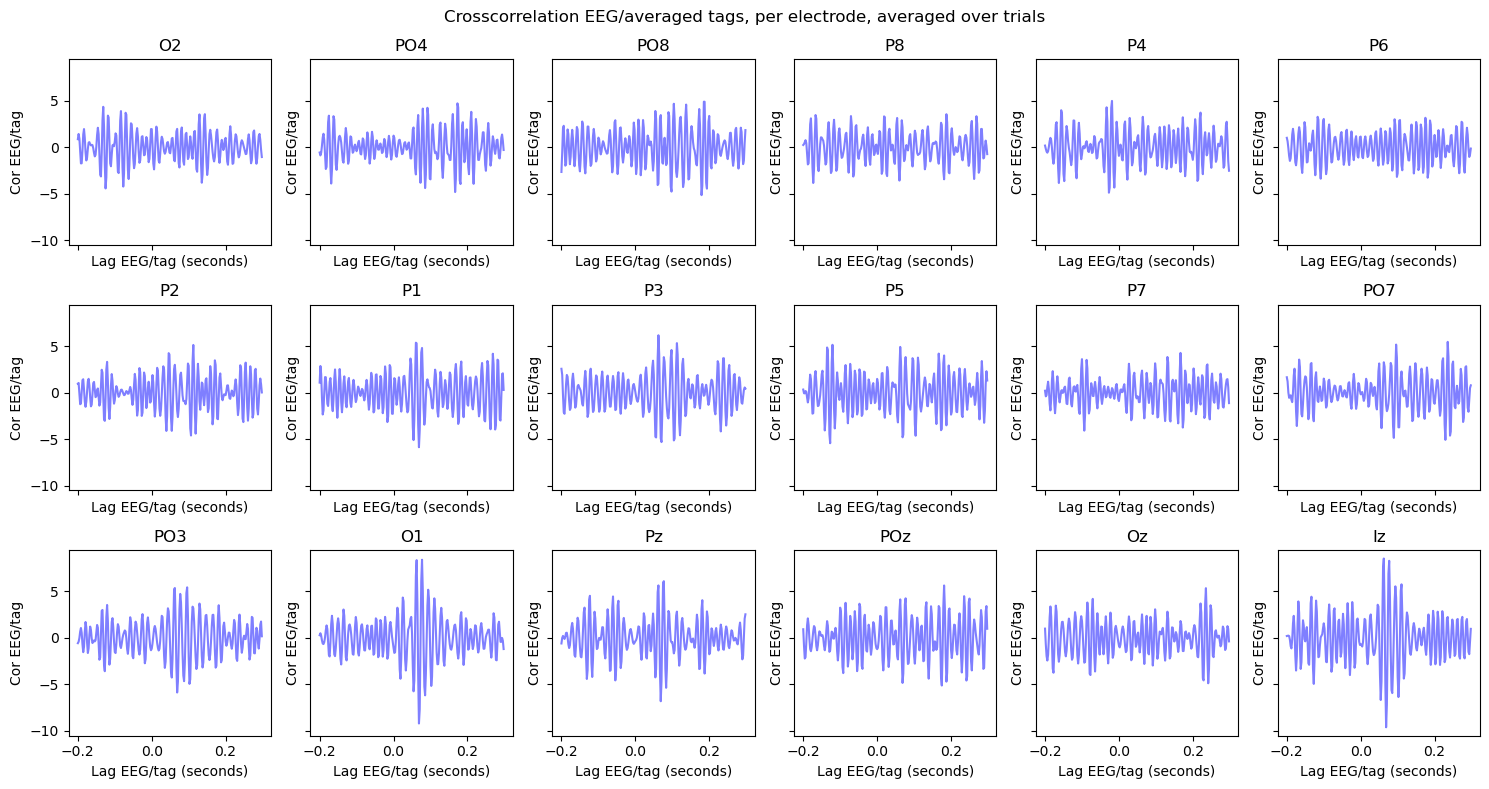

In [18]:
cor_with_avg = np.concatenate([cor_with_avg_for_cuedR,cor_with_avg_for_cuedL])

fig, axs = plt.subplots(3, 6, figsize=(15, 8), sharey=True, sharex=True)
for e, elec in enumerate(relevant_electrodes):
    ax = axs[e // 6, e % 6]
    ax.plot(times[tmin_display:], cor_with_avg[:, e, tmin_display:].mean(axis=0).T, color='blue', alpha=0.5)
    ax.set_title(elec)
    ax.set_xlabel('Lag EEG/tag (seconds)')
    ax.set_ylabel('Cor EEG/tag')
plt.suptitle('Crosscorrelation EEG/averaged tags, per electrode, averaged over trials')
plt.tight_layout()
plt.show()


Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_85470/2817541534.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(cor_with_avg, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


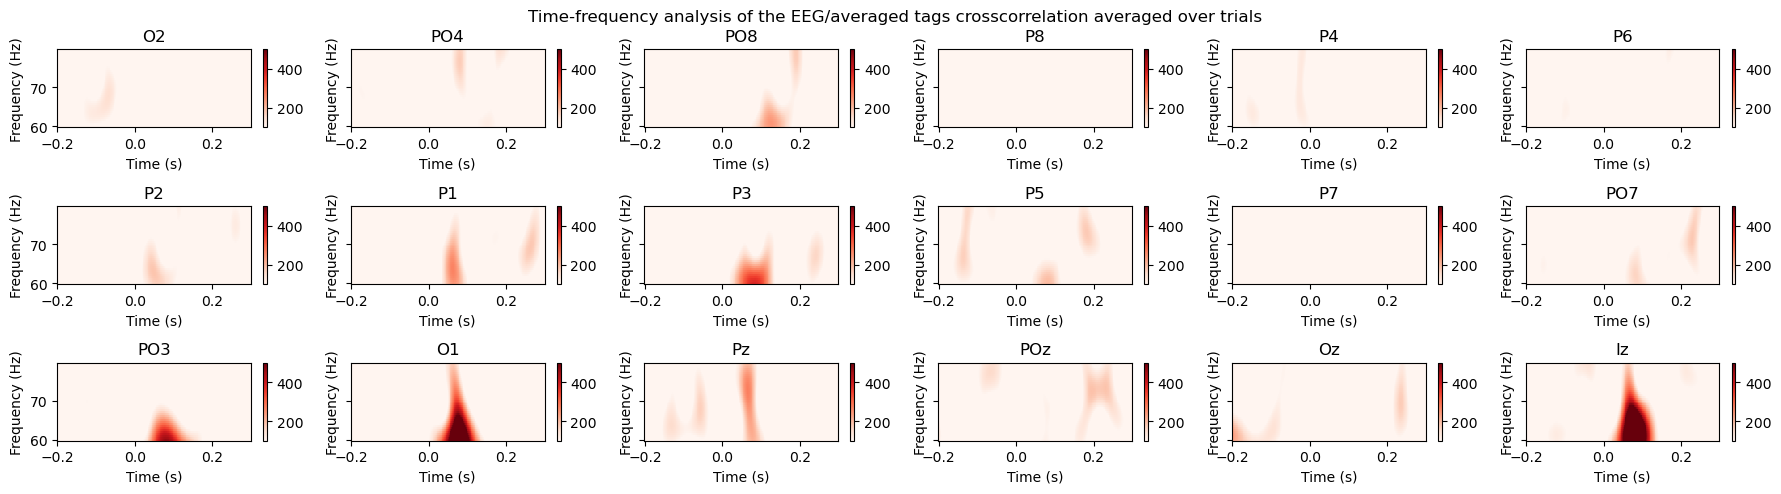

In [19]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).resample(sfreq)
# Do the time frequency analysis
tfr = mne.time_frequency.tfr_array_morlet(cor_with_avg, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)
# Store in MNE format
tfr = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([tfr.mean(axis=0)]), epochs_noistag_cropped.times, freqs)

# Plot
fig, axes = plt.subplots(3, 6, figsize=(18, 5), sharey = True) 
axes = axes.flatten() 
channels = epochs_noistag_cropped.info['ch_names']
for e, (channel, ax) in enumerate(zip(channels, axes)):
    tfr.plot(
        [channel],
        tmin=-.2,
        baseline=(None,0),
        vlim=(100, 500),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
plt.tight_layout()
plt.suptitle('Time-frequency analysis of the EEG/averaged tags crosscorrelation averaged over trials')
plt.show()

In [20]:
# Select electrodes that have a crosscorrelation max higher than 3.8 standard deviations after stimulus onset
elec_max = np.abs(normalize_per_trial(cor_with_avg.mean(axis=0)))[:, -int((tmax_eeg-tmax_noise)*sfreq):].max(axis=-1) > 3.8
best_indices = [i for i in range(len(elec_max)) if elec_max[i]]
best_electrodes = [epochs_noistag.info['ch_names'][i] for i in best_indices]
epochs_noistag = epochs_noistag.pick(best_electrodes)
best_electrodes

['O1', 'Pz', 'Iz']

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


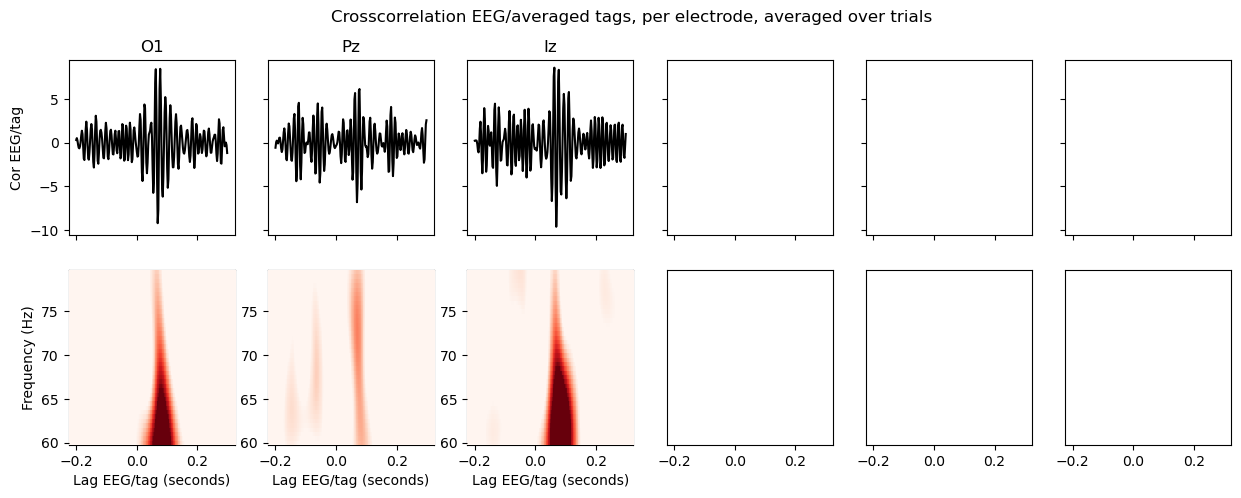

In [21]:
cor_with_avg = np.concatenate([cor_with_avg_for_cuedR,cor_with_avg_for_cuedL])

fig, axs = plt.subplots(2,6, figsize=(15, 5), sharey='row', sharex=True)
for e, elec in enumerate(best_electrodes):
    elec_idx = np.where(np.array(epochs.info['ch_names']) == elec)[0]
    axs[0,e].plot(times[tmin_display:], cor_with_avg[:, elec_idx, tmin_display:].mean(axis=0).T, color='black')
    axs[0,e].set_title(elec)

    tfr_axes = fig.add_subplot(2, 6, e + 7, frame_on=False)
    b = tfr.plot(
        [elec],
        tmin=-.2,
        baseline=(None, 0),
        vlim=(100, 500),
        axes=tfr_axes,
        colorbar=False,
        show=False
    )
    tfr_axes.set_xlabel('')
    if e != 0:
        tfr_axes.set_ylabel('')
    tfr_axes.tick_params(left=True, labelleft=True, bottom=False, labelbottom=False)
    axs[1,e].set_xlabel('Lag EEG/tag (seconds)')
    axs[1,e].set_yticks([])
axs[0,0].set_ylabel('Cor EEG/tag')
plt.suptitle('Crosscorrelation EEG/averaged tags, per electrode, averaged over trials')
# plt.tight_layout()
plt.show()


In [22]:
# Export for group visualization
# First average over trials, normalize the crosscorrelation, then average over best electrodes
cor_with_avg_norm = normalize_per_trial(cor_with_avg[:,np.isin(np.array(epochs.info['ch_names']),best_electrodes),:].mean(axis=0)).mean(axis=0)

crosscorr_time = pd.DataFrame({'Time':times,
              'value':cor_with_avg_norm})
crosscorr_time.to_csv('files/A2_crosscorr_time_avgtag.csv')

### 2.1 Comparing cross-correlation pre vs post display

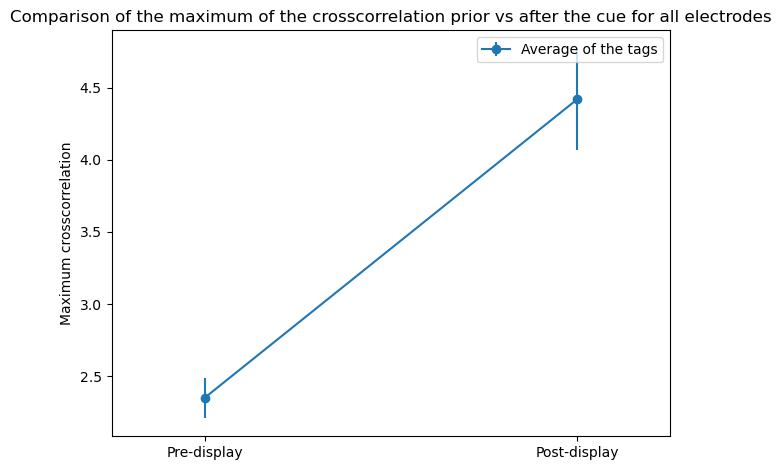

In [23]:
max_precue_avg = np.abs(normalize_per_trial(np.mean(cor_with_avg, axis=0))[best_indices,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_avg = np.abs(normalize_per_trial(np.mean(cor_with_avg, axis=0))[best_indices,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_avg), np.mean(max_postcue_avg)],
                yerr=[np.std(max_precue_avg), np.std(max_postcue_avg)], fmt='o-', label='Average of the tags')
                        
plt.xticks([0,1],['Pre-display', 'Post-display'])
plt.title('Comparison of the maximum of the crosscorrelation prior vs after the cue for all electrodes')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

In [24]:
# Export for group analysis
crosscor_prepost = {}
crosscor_prepost['pre'] = np.abs(normalize_per_trial(np.mean(cor_with_avg, axis=0))[best_indices,:int(times.max()*sfreq)]).max(axis=-1)
crosscor_prepost['post'] = np.abs(normalize_per_trial(np.mean(cor_with_avg, axis=0))[best_indices,-int(times.max()*sfreq):]).max(axis=-1)
crosscor_prepost_df = pd.DataFrame(crosscor_prepost)
crosscor_prepost_df = crosscor_prepost_df.melt()
crosscor_prepost_df['prepost'] = crosscor_prepost_df['variable']
crosscor_prepost_df = crosscor_prepost_df.drop('variable', axis=1)
crosscor_prepost_df.to_csv('files/A2_crosscor_prepost_avgtag.csv',index=False)

### 2.2 Comparing cross-correlation on displayed trial vs others

In [25]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((len(trials), len(trials), len(best_indices), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_averaged_for_cuedL, _, _, _ = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=best_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise,
                                    mean_tags = True)
    # Record trial result
    trial_crosscorr_matL[trial_idx, :, :, :] = cor_with_averaged_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((len(trials), len(trials), len(best_indices), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_averaged_for_cuedR, _, _, _ = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=best_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise,
                                    mean_tags = True)
    # Record trial result
    trial_crosscorr_matR[trial_idx, :, :, :] = cor_with_averaged_for_cuedR[:, :, :]

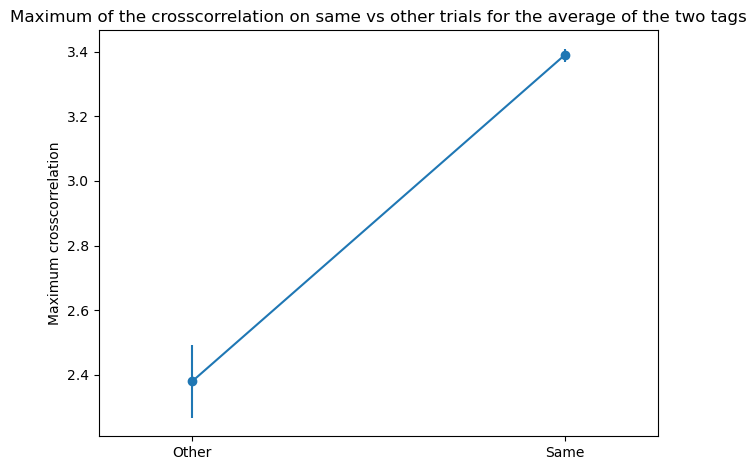

In [26]:
same = []
other = []

num_trials = trial_crosscorr_matL.shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same.append(trial_crosscorr_matL[trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other.append(trial_crosscorr_matL[trial, sampled_index])
    
num_trials = trial_crosscorr_matR.shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same.append(trial_crosscorr_matR[trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other.append(trial_crosscorr_matR[trial, sampled_index])

plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(other).mean(axis=(0)))).max(axis=-1).mean(), np.abs(normalize_per_trial(np.array(same).mean(axis=(0)))).max(axis=-1).mean()],
                yerr=[np.abs(normalize_per_trial(np.array(other).mean(axis=(0)))).max(axis=-1).std(), np.abs(normalize_per_trial(np.array(same).mean(axis=(0)))).max(axis=-1).std()], fmt='o-', label='Average of the tags')
plt.xticks([0,1],['Other','Same'])
plt.title('Maximum of the crosscorrelation on same vs other trials for the average of the two tags')
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

In [27]:
# Export for group analysis
crosscor_sameother = {}
crosscor_sameother['same'] = np.abs(normalize_per_trial(np.array(same).mean(axis=(0)))).max(axis=-1)
crosscor_sameother['other'] = np.abs(normalize_per_trial(np.array(other).mean(axis=(0)))).max(axis=-1)
crosscor_sameother_df = pd.DataFrame(crosscor_sameother)
crosscor_sameother_df = crosscor_sameother_df.melt()
crosscor_sameother_df['trial_type'] = crosscor_sameother_df['variable']
crosscor_sameother_df = crosscor_sameother_df.drop('variable', axis=1)
crosscor_sameother_df.to_csv('files/A2_crosscor_sameother_averaged.csv',index=False)

## 3. Search in subwindows of the tag
The EEG from 0 to 2.3s is correlated with segments of tags (duration = 400ms, step = 100ms, positive time lag up to 1.9s). 
Crosscorrelation is computed for the best noise tagging condition electrodes.

### 3.1 Timing of the crosscorrelation with the average of the two tags
All trials, including the 20% where there was a target are included. 
The EEG is correlated with the average of the two displayed tags instead of each tag.

In [28]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 45
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq

# Matrix to store results
max_values_per_bin = np.zeros((len(noise_periods), n_bins))

# For each of the tag segments
for j, period in enumerate(noise_periods):
    tmin_noise, tmax_noise = period
    # Get the crosscorrelation sliding over the all EEG epoch
    # With the average of the two tags when the cued side was right
    cor_with_avg_for_cuedR, _, idx_avgR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right', \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,\
                      mean_tags = True)
    # With the average of the two tags when the cued side was left
    cor_with_avg_for_cuedL, _, idx_avgL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left',\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,\
                      mean_tags = True)
    # Combine right and left cued side
    avg = np.concatenate([cor_with_avg_for_cuedR,cor_with_avg_for_cuedL])

    # Average over trials, normalize per trial, then for each EEG/Tag segment lag, pick the max crosscorrelation,average over electrodes, 
    for i in range(n_bins):
        start_idx = int(time_bins[i])
        end_idx = int(time_bins[i + 1])
        max_values_per_bin[j, i] = np.mean(np.abs(normalize_per_trial(avg.mean(axis=0))[:,start_idx:end_idx]).max(axis=-1), axis=0)

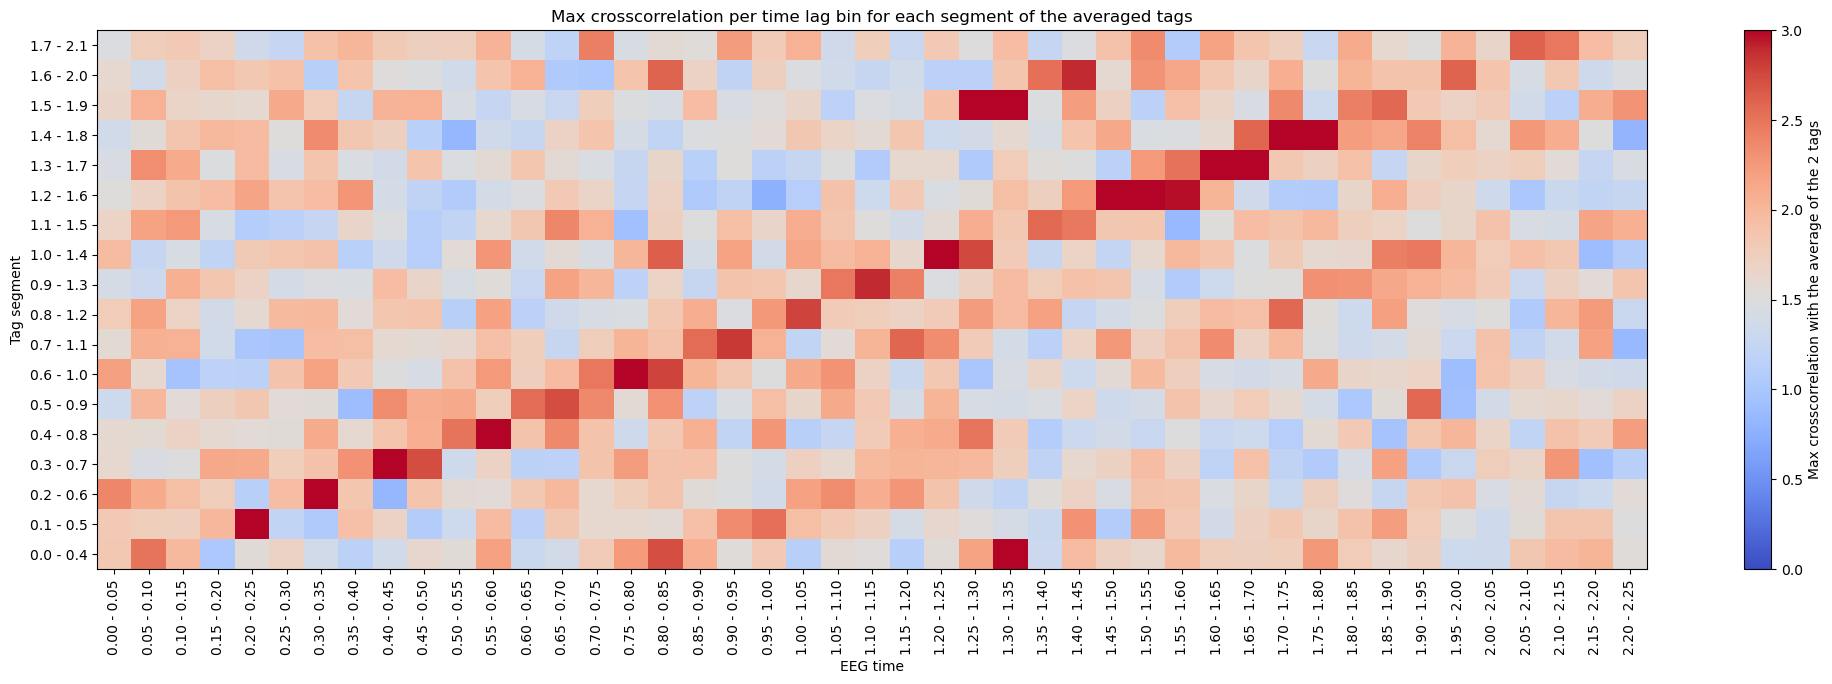

In [29]:
# Plot for the average of the two tags
fig, ax = plt.subplots(figsize=(25,7))
cax = ax.imshow(max_values_per_bin, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)

cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation with the average of the 2 tags')

ax.set_xlabel('EEG time')
ax.set_ylabel('Tag segment')
ax.set_title('Max crosscorrelation per time lag bin for each segment of the averaged tags')

bin_times = np.linspace(start, end, n_bins)
diff_bins = np.diff(bin_times)[0]
ax.set_xticks(np.arange(n_bins))
ax.set_xticklabels([f'{bt:.2f} - {bt+diff_bins:.2f}' for bt in bin_times], rotation=90)
ax.set_yticks(np.arange(len(noise_periods)))
ax.set_yticklabels([f'{i[0]:.1f} - {i[1]:.1f}' for i in noise_periods])

plt.show()

# Export results
np.save('files/averaged_tags_A2', max_values_per_bin)

### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [30]:
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq
max_values_per_bin_cued = np.zeros((len(noise_periods), n_bins))
max_values_per_bin_uncued = np.zeros((len(noise_periods), n_bins))

for j, period in enumerate(noise_periods):
    tmin_noise, tmax_noise = period
    
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
    uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

    for i in range(n_bins):
        start_idx = int(time_bins[i])
        end_idx = int(time_bins[i + 1])
        max_values_per_bin_cued[j, i] = np.mean(np.abs(normalize_per_trial(cued.mean(axis=0))[:, start_idx:end_idx]).max(axis=-1), axis=0)
        max_values_per_bin_uncued[j, i] = np.mean(np.abs(normalize_per_trial(uncued.mean(axis=0))[:, start_idx:end_idx]).max(axis=-1), axis=0)


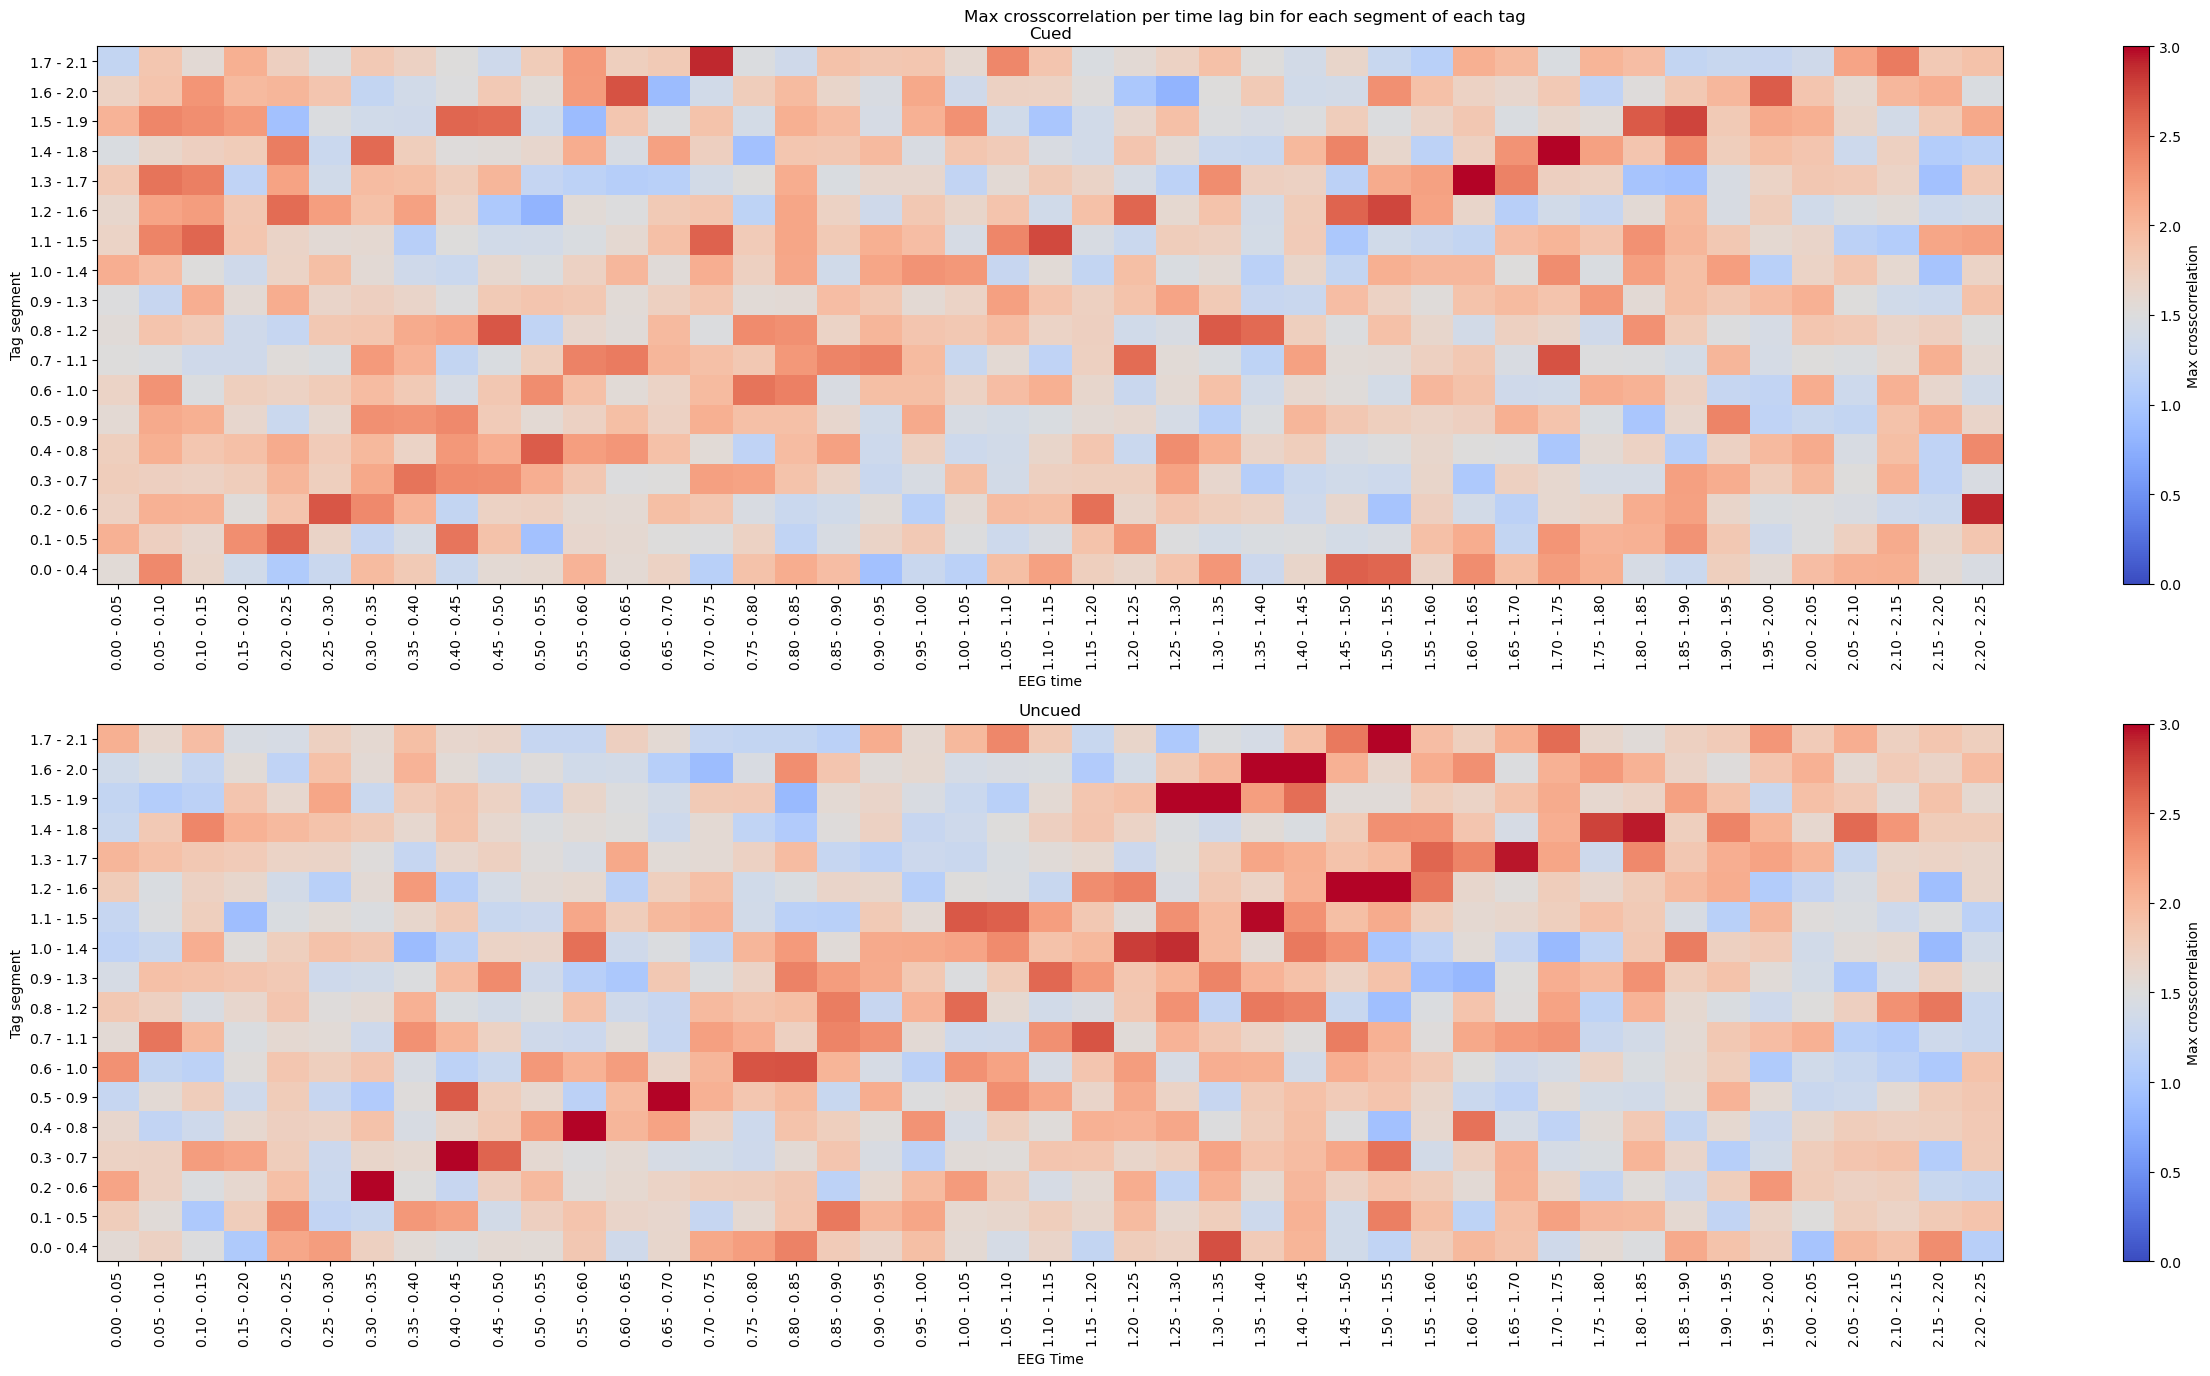

In [31]:
fig, ax = plt.subplots(2,1, figsize=(25,14))

cax = ax[0].imshow(max_values_per_bin_cued, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')
cax = ax[1].imshow(max_values_per_bin_uncued, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

ax[0].set_xlabel('EEG time')
ax[0].set_ylabel('Tag segment')
ax[1].set_xlabel('EEG Time')
ax[1].set_ylabel('Tag segment')
plt.suptitle('Max crosscorrelation per time lag bin for each segment of each tag')

bin_times = np.linspace(start, end, n_bins)
diff_bins = np.diff(bin_times)[0]

for axi in ax:
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.2f} - {bt+diff_bins:.2f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'{i[0]:.1f} - {i[1]:.1f}' for i in noise_periods])


ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.tight_layout()
plt.show()
np.save('files/cued_tags_with_target_A2', max_values_per_bin_cued)
np.save('files/uncued_tags_with_target_A2', max_values_per_bin_uncued)

## 4. Testing by-trial recovery of the noise tags

We use the same/other comparison but try to find evidence for a trial level representation of the noise tag. For this we first compare the distributions between maximum crosscorrelation for trials were the tag was presented (same) to trials where the tag was not presented (other).

### 4.1 Using a t-test on the distribution same vs other trials max crosscorrelation

T-test for same vs others on cued:TtestResult(statistic=-1.4738272639851888, pvalue=0.14213850685455018, df=195.25175928296235)


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


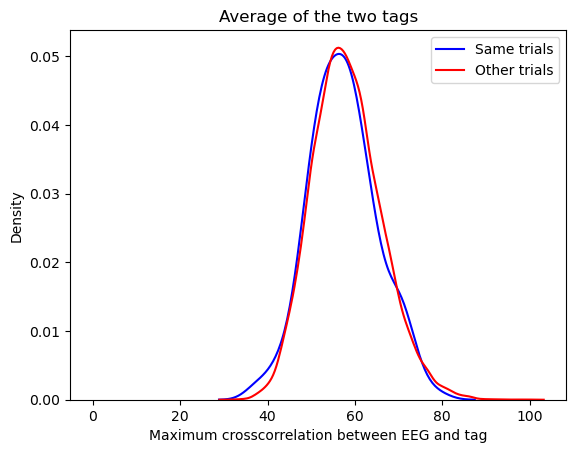

In [32]:
# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL[:, :, :,:].max(axis=-1)), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR[:, :, :,:].max(axis=-1)), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial,other_trial,equal_var=False)}')
sns.kdeplot(same_trial, color='blue')
sns.kdeplot(other_trial, color='red')
plt.plot([0],[0], label='Same trials', color='blue')
plt.plot([0],[0], label='Other trials', color='red')
plt.xlabel('Maximum crosscorrelation between EEG and tag')
plt.title('Average of the two tags')
plt.legend()

### 4.2 Windowing the tag to test for same vs other 
We look for a significant effect based on the trial max crosscorrelation in different time period of the noise and the EEG for windows of .4s and a positive lag between noise and EEG of .1s

In [33]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax

# Define lag
lag = .1

# Define period of noise to analyze
start = 0
duration = .4
step = .4
end = tmax_eeg-lag

# Create a list of tag segments
noise_periods = generate_noise_periods(start, end, duration, step)

# Matrix to store results
max_values_per_bin = np.zeros((len(noise_periods)+1, len(epochs_noistag)))

# For each of the tag segments
for j, period in enumerate(noise_periods):
    j += 1 #First period is baseline below
    tmin_noise, tmax_noise = period
    tmin_eeg_period, tmax_eeg_period = period
    tmax_eeg_period += lag
    
    # Get the crosscorrelation sliding over the all EEG epoch
    # With the average of the two tags when the cued side was right
    cor_with_avg_for_avgR, _, idx_avgR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',  electrodes=best_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)

    # get other trial crosscorrelation
    other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'left', best_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialL = np.abs(other_trialL).max(axis=-1).mean(axis=2).flatten()
    
    # With the average of the two tags when the avg side was left
    cor_with_avg_for_avgL, _, idx_avgL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=best_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)
    # get other trial crosscorrelation for right
    other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', best_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialR = np.abs(other_trialR).max(axis=-1).mean(axis=2).flatten()
    # Combine right and left avg side
    avg = np.concatenate([cor_with_avg_for_avgR,cor_with_avg_for_avgL])
    # Combine other trials for left and right avg side
    other = np.concatenate([other_trialR, other_trialL])

    # pick the max crosscorrelation, average over electrodes
    max_values_per_bin[j, :] = np.mean(np.abs(avg).max(axis=-1), axis=1) - other.mean()

# Baseline to compare with (intercept of the linear model) is the first part of the noise with the baseline EEG
tmin_noise, tmax_noise = 0, .4
tmin_eeg_period, tmax_eeg_period = -.5, 0

# Get the crosscorrelation sliding over the all EEG epoch
# With the average of the two tags when the cued side was right
cor_with_avg_for_avgR, _, idx_avgR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right',  electrodes=best_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
    tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)

# get other trial crosscorrelation
other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, \
'left', best_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
# take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
other_trialL = np.abs(other_trialL).max(axis=-1).mean(axis=2).flatten()

# With the average of the two tags when the avg side was left
cor_with_avg_for_avgL, _, idx_avgL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=best_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
    tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = True)
# get other trial crosscorrelation for right
other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', best_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
# take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
other_trialR = np.abs(other_trialR).max(axis=-1).mean(axis=2).flatten()
# Combine right and left avg side
avg = np.concatenate([cor_with_avg_for_avgR,cor_with_avg_for_avgL])
# Combine other trials for left and right avg side
other = np.concatenate([other_trialR, other_trialL])

# pick the max crosscorrelation, average over electrodes
max_values_per_bin[0, :] = np.mean(np.abs(avg).max(axis=-1), axis=1) - other.mean()

#Add baseline to noise_periods
noise_periods.insert(0, (-0.4,0))


We fit a linear mixed effect model with the periods as predictor (baseline is intercept) and trial random effect for intercept and slopes

In [34]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = [f'{x[0]:.1f}s' for i,x in enumerate(noise_periods)]
df_trial['trial'] = np.arange(len(df_trial))
df_trial_long = df_trial.melt(id_vars='trial', var_name='variable', value_name='value')

# Perform one-hot encoding on the noise periods
one_hot_encoded = pd.get_dummies(df_trial_long['variable'])

design_matrix = pd.concat([df_trial_long['value'],one_hot_encoded], axis=1)
trials =  df_trial_long['trial']

# Fit a LME
md = smf.mixedlm("value ~ Q('0.0s')+ Q('0.4s')+ Q('0.8s')+ Q('1.2s')+ Q('1.6s')", design_matrix, 
                 groups=trials, re_formula="~ 1 + Q('0.0s')+ Q('0.4s')+ Q('0.8s')+ Q('1.2s') + Q('1.6s')")
result = md.fit()
print(result.summary())

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          value     
No. Observations:            1152             Method:                      REML      
No. Groups:                  192              Scale:                       15.9356   
Min. group size:             6                Log-Likelihood:              -3354.0576
Max. group size:             6                Converged:                   Yes       
Mean group size:             6.0                                                     
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                  -0.190    0.356 -0.533 0.594 -0.888  0.508
Q('0.0s')[T.True]                           0.053    0.415  0.128 0.898 -0.760

### 4.3 Coherence as a mechanism for tag presence on the mean crosscorrelation

Given that the tag doesn't seem to be recoverable at the trial level, it may be that phase coherence of the tag's crosscorrelation at the trial level make it visible on the averaged cross-correlation.

/tmp/ipykernel_85470/1637586307.py:36: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_same = mne.time_frequency.tfr_array_morlet(same, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
/tmp/ipykernel_85470/1637586307.py:37: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_other = mne.time_frequency.tfr_array_morlet(other, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


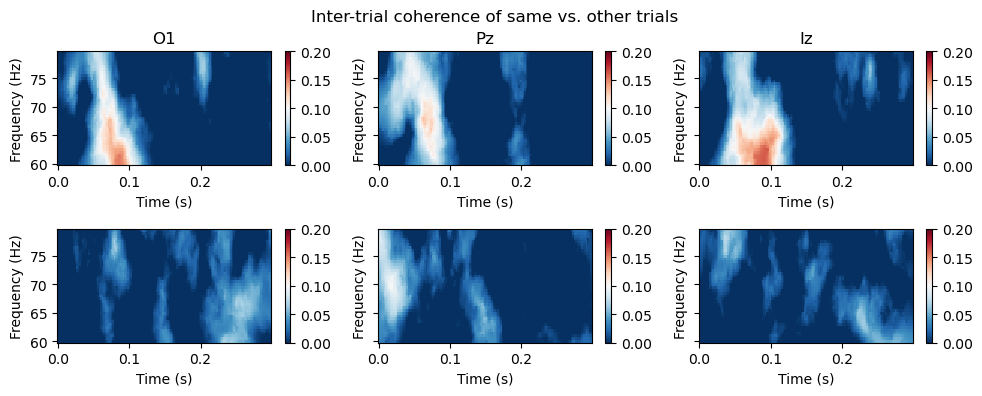

In [35]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)

# Concatenate same and other (pick a random other for each same)
same = []
other = []

num_trials = trial_crosscorr_matL.shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same.append(trial_crosscorr_matL[trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other.append(trial_crosscorr_matL[trial, sampled_index])
    
num_trials = trial_crosscorr_matR.shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same.append(trial_crosscorr_matR[trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other.append(trial_crosscorr_matR[trial, sampled_index])

# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(best_electrodes)
# Do the inter-trial coherence analysis
itc_same = mne.time_frequency.tfr_array_morlet(same, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
itc_other = mne.time_frequency.tfr_array_morlet(other, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_same]), epochs_noistag_cropped.times, freqs)
itc_other = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_other]), epochs_noistag_cropped.times, freqs)


# Plot
fig, axes = plt.subplots(2, len(best_electrodes), figsize=(10, 4), sharey = True) 
channels = epochs_noistag_cropped.info['ch_names']
for e, channel in enumerate(channels):
    itc_same.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[0,e],
        colorbar=True,
        show=False 
    )
    axes[0,e].set_title(channel) 
    itc_other.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[1,e],
        colorbar=True,
        show=False 
    )
plt.tight_layout()
plt.suptitle('Inter-trial coherence of same vs. other trials')
plt.show()